In [1]:
# Librerías necesarias
import boto3
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Conexión con Athena
session = boto3.Session(profile_name='profeco', region_name='us-east-1')


#### *Creamos la tabla 'profeco' dentro de la base de datos de 'profeco_db' en Athena.*

In [3]:
query = '''
CREATE EXTERNAL TABLE IF NOT EXISTS profeco_db.profeco (
    `producto` string,
    `presentacion` string,
    `marca` string,
    `categoria` string,
    `precio` double,
    `fecharegistro` date,
    `cadenacomercial` string,
    `giro` string,
    `nombrecomercial` string,
    `direccion` string,
    `estado` string,
    `municipio` string,
    `latitud` double,
    `longitud` double
    ) COMMENT "Profeco: ¿quién es quien?"
    PARTITIONED BY (catalogo string, anio int)
    STORED AS PARQUET
    LOCATION 's3://proyectoprofeco/data/parquets/'
'''

In [ ]:
#MSCK REPAIR TABLE profeco_db.profeco

In [4]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

""


# **Parte B**

# De acuerdo a la categoría que te haya tocado obtén (desde 2018 a 2022) la siguiente información. A nuestro equipo le tocó 'básicos'.

# ¿De qué año a qué año tienen datos de esa categoría?

In [5]:
query1 = '''
select anio, count(1) as conteo
from profeco_db.profeco
where catalogo = 'basicos'
group by anio
order by anio
'''

wr.athena.read_sql_query(
    query1, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,anio,conteo
0,2018,8804761
1,2019,7398860
2,2020,6170515
3,2021,6919490
4,2022,7945110
5,2023,7742108
6,2024,1986577


#### *Se tienen datos desde el 2018 hasta el 2024.*

# ¿Cuántos registros de fecha hay vacíos?

In [6]:
query2 = '''
select count(*) as fechas_vacios
from profeco_db.profeco
where fecharegistro is null
'''

wr.athena.read_sql_query(
    query2, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,fechas_vacios
0,0


In [ ]:
query2b = '''
select distinct fecharegistro
from profeco_db.profeco
order by 1
'''

res2 = wr.athena.read_sql_query(
    query2b, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

In [ ]:
#Lo mandamos a un csv para comprobar que no había fechas nulas.
#res2.to_csv('resultado.csv', index=False)

#### *No existen registros de fechas vacíos.*

# ¿Cuántos registros tienes por año?

In [7]:
query3 = '''
select anio, count(1) as total_registros
from profeco_db.profeco
group by anio
order by anio
'''

wr.athena.read_sql_query(
    query3, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,anio,total_registros
0,2018,16782901
1,2019,13682091
2,2020,10780481
3,2021,12813994
4,2022,14449481
5,2023,14782812
6,2024,3624947


#### *El número de registros oscila entre 10 y 16 millones entre 2018 y 2023. Los registros en 2024 son menores porque por el momento solo se tienen 3 meses registrados.*

# ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [8]:
query4 = '''
SELECT
    anio,
    catalogo,
    MIN(precio) AS precio_minimo,
    MAX(precio) AS precio_maximo,
    AVG(precio) AS precio_promedio,
    STDDEV_POP(precio) AS desviacion_estandar,
    APPROX_PERCENTILE(precio, 0.5) AS precio_mediano,
    APPROX_PERCENTILE(precio, 0.25) AS cuantil_25,
    APPROX_PERCENTILE(precio, 0.75) AS cuantil_75
FROM profeco_db.profeco p1
WHERE p1.catalogo = 'basicos'
GROUP BY anio, catalogo;
'''

wr.athena.read_sql_query(
    query4, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,anio,catalogo,precio_minimo,precio_maximo,precio_promedio,desviacion_estandar,precio_mediano,cuantil_25,cuantil_75
0,2023,basicos,1.2,869.0,65.701468,68.851437,42.090749,24.622288,79.581917
1,2019,basicos,1.0,659.9,47.617151,50.498666,30.555439,17.104487,56.164400
2,2022,basicos,1.0,690.0,59.716877,62.383832,38.924053,22.792930,70.552928
3,2018,basicos,1.0,899.0,46.443535,48.804694,29.760655,16.943146,55.225849
4,2021,basicos,1.0,798.9,53.788488,56.237455,34.453928,20.070492,64.801552
5,2020,basicos,1.0,844.9,51.223467,53.187702,33.100282,18.696192,60.870983
6,2024,basicos,1.3,799.0,66.911763,70.214765,42.660509,25.587265,80.534254


#### *En la tabla anterior, se muestran las estadísticas para el catálogo de 'básicos' por año.*

# ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dio lo mismo en Spark?

In [9]:
query5 = '''
WITH ranked_brands AS (
    SELECT
        estado,
        marca,
        precio,
        ROW_NUMBER() OVER (PARTITION BY estado, marca ORDER BY precio DESC) AS rank
    FROM
        profeco_db.profeco
),
ranked AS (
    SELECT
        estado,
        marca,
        precio,
        rank,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio DESC) AS rank2
    FROM
        ranked_brands
    WHERE
        rank = 1
),
ranked_states AS (
    SELECT
        estado,
        marca,
        precio,
        rank2
    FROM
        ranked
    WHERE
        rank2 <= 5
)
SELECT * FROM ranked_states;
'''

wr.athena.read_sql_query(
    query5, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,estado,marca,precio,rank2
0,tabasco,sony_bravia,99999.0,1
1,tabasco,lg,79999.0,2
2,tabasco,samsung,76990.0,3
3,tabasco,hp,69935.0,4
4,tabasco,huawei,49999.0,5
...,...,...,...,...
155,jalisco,sony_bravia,109999.0,1
156,jalisco,samsung,96999.0,2
157,jalisco,lg,79999.0,3
158,jalisco,hisense,55499.0,4


#### *Destaca que, en general, las marcas en el top 5 con mayores precios son de productos electrodomésticos. Lo obtenido en esta tabla refleja información distinta a la obtenida en Spark, donde la marca con mayor precio era diva_cup con 869 pesos.*

# ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dio lo mismo en Spark?

In [10]:
query6 = '''
SELECT 
    marca,
    min(precio) AS min_precio
FROM
    profeco_db.profeco
WHERE
    estado = 'ciudad_de_mexico'
GROUP BY marca
ORDER BY 
    2 ASC
LIMIT 5
'''

wr.athena.read_sql_query(
    query6, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,marca,min_precio
0,sm,0.87
1,clight,1.20
2,frutimax,1.50
3,fud,2.00
4,zuko,2.00


#### *La marca con menor precio en la CDMX coincide con lo obtenido en Spark. Si bien la marca es clight en ambos casos, en spark aparecía con un precio de 1.0 y aquí con un precio de 1.20.*

# ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dio lo mismo en Spark?

In [11]:
query7 = '''
SELECT
    marca,
    COUNT(*) AS total_observaciones
FROM
    profeco_db.profeco
GROUP BY
    marca
ORDER BY
    total_observaciones DESC
LIMIT 5
'''

wr.athena.read_sql_query(
    query7, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,marca,total_observaciones
0,sm,27947345
1,la_costena,1397026
2,fud,1186655
3,mabe,921845
4,bimbo,853645


#### *La marca con mayores observaciones coincide con lo obtenido en Spark, al ser La Costeña con 1,397,026 observaciones (similar a lo obtenido en Spark).*

# Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.

In [12]:
query8 = '''
WITH ranked_brands AS (
    SELECT
        anio,
        marca,
        COUNT(*) AS total_observaciones,
        ROW_NUMBER() OVER (PARTITION BY anio ORDER BY COUNT(*) DESC) AS rank
    FROM
        profeco_db.profeco
    WHERE
        catalogo = 'basicos'
    GROUP BY
        anio, marca
)
SELECT
    anio,
    marca,
    total_observaciones
FROM
    ranked_brands
WHERE
    rank <= 5
ORDER BY anio
'''

tabla8 = wr.athena.read_sql_query(
    query8, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

tabla8

,anio,marca,total_observaciones
0,2018,sm,529736
1,2018,la_costena,259872
2,2018,fud,236425
3,2018,lala,152647
4,2018,bimbo,134747
5,2019,sm,433446
6,2019,la_costena,204037
7,2019,fud,184612
8,2019,bimbo,140771
9,2019,lala,118609


#### *El top 5 de marcas con mayor número de observaciones por año arrojan 7 marcas distintas, por lo que no cambian mucho en el tiempo. Siendo las principales: La Costeña, Fud, Bimbo, Sabritas y Lala.* 

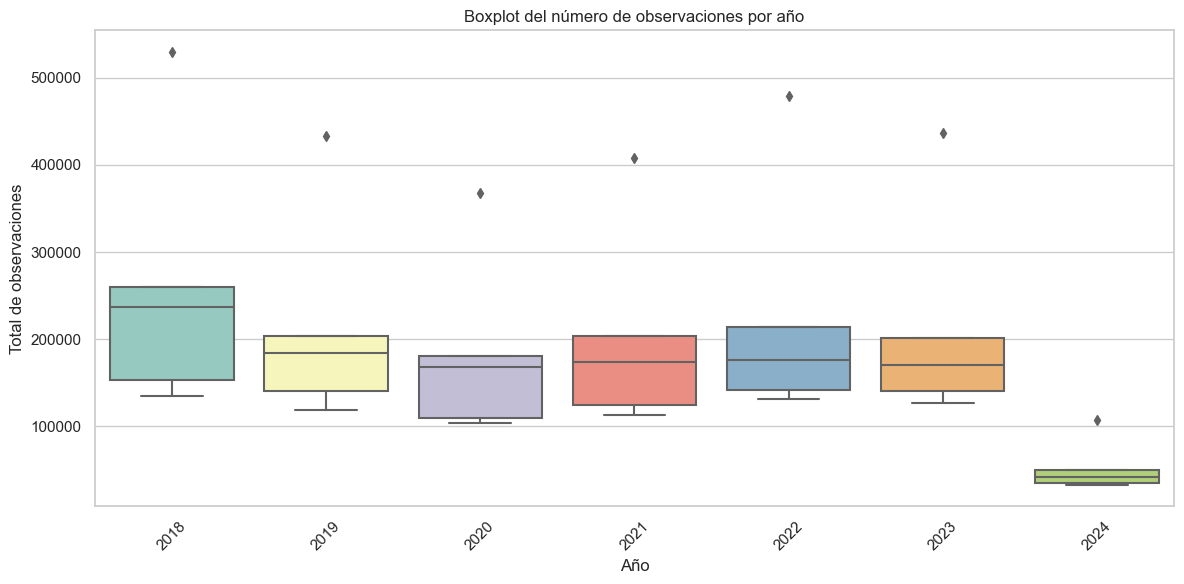

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=tabla8, x='anio', y='total_observaciones', palette='Set3')
plt.title('Boxplot del número de observaciones por año')
plt.xlabel('Año')
plt.ylabel('Total de observaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Nota**: ¡¡¡Lo principal aqui es tu código de SQL para construir las tablas!!! Eso es lo que voy a calificar. R y Pandas, están ahí para que puedas gráficar y hacer tus tablas bonitas en el reporte, OJO no para sacar las estadísticas.

## **Hint**: Guarda tus consultas en archivos que puedas guardar en S3 y luego leer desde Pandas o RStudio, para hacer tus gráficas o cuadros compartivos.